# Bulk Forecast

Geração de previsões para multiplas categorias

In [1]:
import pandas as pd
import numpy as np
import json

from fbprophet import Prophet

in_data = pd.read_csv('geral.csv', index_col=0)
in_data_1 = pd.read_csv('previsao_geral.csv', index_col=0)

categories = json.load(open('subcategorias.json'))
regions = json.load(open('regioes.json'))

out_data = pd.DataFrame(np.zeros((len(categories.keys()), 11)), columns=['Mes', 'Ano', 'Categoria', 'Produto', 'Compra sugerida', 'Venda prevista', 'Venda anterior', 'Estoque atual', 'Estoque anterior', 'Valor venda', 'Valor anterior'])

### Adicionar cobertura de estoque das categorias


In [2]:
in_data_stock = pd.read_csv('estoque.csv', index_col=0)
in_data_facts = pd.read_csv('fatos.csv')

In [3]:
for category in categories:
    in_data_1[category] = in_data_1[categories[category]].sum(axis=1)

In [4]:
forecast_cumsum = in_data_1[categories.keys()].cumsum()

In [5]:
# Correção dos estoques
for category in categories:
    in_data_facts.loc[in_data_facts['Categoria'] == category, 'Estoque atual'] = in_data_stock[categories[category]].sum(axis=1)['2021-03-15']
    in_data_facts.loc[in_data_facts['Categoria'] == category, 'Estoque anterior'] = in_data_stock[categories[category]].sum(axis=1)['2021-02-27']
    
stock = in_data_facts[['Categoria', 'Estoque atual']]
stock.index = stock['Categoria']
stock = stock['Estoque atual']

In [6]:
in_data_facts['Cobertura'] = 0
for category in categories:
    in_data_facts.loc[in_data_facts['Categoria'] == category, 'Cobertura'] = len(forecast_cumsum.loc[forecast_cumsum[category] < stock[category], category])

In [8]:
in_data_facts.to_csv('fatos.csv')

### Obter estoques

In [2]:
dfs = []
for month in ['JAN', 'FEB', 'MAR']:
    dfs.append(pd.read_csv('./2021/' + month +'.txt', delimiter=';', header=None))

in_data_2 = pd.concat(dfs)

in_data_2.columns = ['Chave Filial + Produto',
'Código Filial',
'Código Produto é com 6 caracteres',
'Descrição de produto',
'Ponto de reposição',
'A classificar',
'Saldo do produto',
'Qtd Reserva',
'Saldo disponível',
'Dia',
'Filial + Código Produto + Dia (Chave primária)',
'CD de abastecimento'
]

in_data_2 = in_data_2.astype({"Dia": str})

in_data_2['Dia'] = in_data_2['Dia'].apply(lambda x : x[:4] + '-' + x[4:6] + '-' + x[6:])
in_data_2['Dia'] = pd.to_datetime(in_data_2['Dia'])

In [3]:
in_data['GERAL'] = in_data.sum(axis=1)

In [14]:
in_data.index = pd.to_datetime(in_data.index)

a = in_data.resample('M').sum()
a.loc[(a.index.month == 3) & (a.index.year == 2021), 'GERAL'][0]

299438

In [23]:
filtered_data = in_data[categories['ELETRO LINHA BRANCA']]
filtered_data.index = pd.to_datetime(filtered_data.index)
filtered_data = filtered_data.loc[(in_data.index.month == 3) & (in_data.index.year == 2021)]

top_series = filtered_data.sum().sort_values(ascending=False)
a = pd.DataFrame({'Produto': top_series.index, 'Qtd. vendida': top_series.values}, index=range(1, len(top_series) + 1))

In [43]:
b = in_data.loc[(in_data.index.month == 2) & (in_data.index.year == 2021), a['Produto'].unique()].sum()
a['Anterior'] = b.values

In [45]:
b

FRITADEIRA AIR FRYER AF-30 I FAMILY IV 3,5L    1306
FOGAO 4BC. AGATA 4062 BR                        556
LAVADORA PAOLA 10KG PRETA                       744
LAVADORA PAOLA 10KG BR/LILAS                    496
LAVADORA PAOLA 10KG BRANCA/FUME                 412
                                               ... 
LAVADORA LTD13 220V 60HZ                          0
REFRIGERADOR NR-BB53GV3BB 425L PT INVERTER        0
FOGAO 4BC. CARIBE 4078 BR                         0
FORNO MICROONDAS 20L MTO30 BRANCO                 0
LAVADORA AUTOMATICA NA-F120B5GB                   0
Length: 496, dtype: int64

In [3]:
sum_stock = in_data_2[in_data_2['Dia'] == '2021-03-15'].groupby('Descrição de produto').sum().T
sum_stock_1 = in_data_2[in_data_2['Dia'] == '2021-02-27'].groupby('Descrição de produto').sum().T

In [2]:
df_stock = pd.DataFrame(index=['Estoque disponível'], columns=in_data.columns)
df_stock.fillna('0', inplace=True)

df_stock_1 = df_stock.copy(deep=True)

In [5]:
for (stock, stock_1,  product) in zip(sum_stock.loc['Saldo disponível'], sum_stock_1.loc['Saldo disponível'], in_data.columns):
    df_stock[product] = stock
    df_stock_1[product] = stock_1

## Geração da tabela de fatos
Adicionar compra sugerida, venda prevista, estoque atual, estoque anterior, valor venda, valor anterior.

In [8]:
i = 0
for key in categories.keys():
    in_data[key] = in_data[categories[key]].sum(axis=1)
    in_data_1[key] = in_data_1[categories[key]].sum(axis=1)
    row = pd.Series([3, 2021, 
                     key, key, 
                     0, # Compra sugerida, adicionado posteriormente no código
                     in_data_1.loc['2021-03-01':'2021-03-31', key].sum(), # Venda prevista
                     in_data.loc['2021-03-01':'2021-03-31', key].sum(), # Venda anterior
                     df_stock[categories[key]].sum(axis=1), # Estoque atual
                     df_stock_1[categories[key]].sum(axis=1), # Estoque anterior
                     0, # Valor venda, indisponível
                     0]) # Valor anterior, indisponível
    out_data.iloc[i] = row
    i+= 1

In [ ]:
#Tabela de fatos para lojas
i = 0
for key in regions.keys():
    for store in regions[key]:
        in_data[key] = in_data[categories[key]].sum(axis=1)
        in_data_1[key] = in_data_1[categories[key]].sum(axis=1)
        row = pd.Series([3, 2021, 
                         key, key, 
                         0, # Compra sugerida, adicionado posteriormente no código
                         in_data_1.loc['2021-03-01':'2021-03-31', key].sum(), # Venda prevista
                         in_data.loc['2021-03-01':'2021-03-31', key].sum(), # Venda anterior
                         df_stock[categories[key]].sum(axis=1), # Estoque atual
                         df_stock_1[categories[key]].sum(axis=1), # Estoque anterior
                         0, # Valor venda, indisponível
                         0]) # Valor anterior, indisponível
        out_data.iloc[i] = row
        i+= 1

In [9]:
out_data['Compra sugerida'] = out_data['Venda prevista'] - out_data['Estoque atual']
#out_data['Compra sugerida'] = out_data['Compra sugerida'].apply(lambda x : x if x > 0 else 0)

In [10]:
out_data

,Mes,Ano,Categoria,Produto,Compra sugerida,Venda prevista,Venda anterior,Estoque atual,Estoque anterior,Valor venda,Valor anterior
0,3.0,2021.0,ELETRO LINHA BRANCA,ELETRO LINHA BRANCA,-42145.0,3902.0,3964.0,46047.0,62008.0,0.0,0.0
1,3.0,2021.0,AR E VENTILACAO,AR E VENTILACAO,234.0,6220.0,4338.0,5986.0,10069.0,0.0,0.0
2,3.0,2021.0,ELETRODOMESTICOS,ELETRODOMESTICOS,-22781.0,3875.0,4624.0,26656.0,30873.0,0.0,0.0
3,3.0,2021.0,ELETRO TV E SOM,ELETRO TV E SOM,-16229.0,3291.0,2363.0,19520.0,27346.0,0.0,0.0
4,3.0,2021.0,TV E VIDEO,TV E VIDEO,1591.0,3502.0,2773.0,1911.0,7092.0,0.0,0.0
5,3.0,2021.0,ELETRO TELEFONIA CELULAR,ELETRO TELEFONIA CELULAR,-33074.0,11039.0,11602.0,44113.0,19842.0,0.0,0.0
6,3.0,2021.0,ELETRO INFORMATICA,ELETRO INFORMATICA,-23193.0,414.0,184.0,23607.0,12334.0,0.0,0.0
7,3.0,2021.0,MOVEIS COLCHAO,MOVEIS COLCHAO,-12165.0,2003.0,1670.0,14168.0,22769.0,0.0,0.0
8,3.0,2021.0,ELETRO PORTATEIS,ELETRO PORTATEIS,-53831.0,11778.0,7211.0,65609.0,66185.0,0.0,0.0
9,3.0,2021.0,AR E VENTILAÇÃO,AR E VENTILAÇÃO,2139.0,3885.0,2188.0,1746.0,5496.0,0.0,0.0


In [11]:
out_data.to_csv('fatos.csv')

In [20]:
in_data.to_csv('geral.csv') # Salvar a serie temporal de vendas com a adição das categorias

In [4]:
in_data.index = pd.to_datetime(in_data.index)

In [6]:
category_products = categories['ELETRO LINHA BRANCA']
filtered_data = in_data[category_products]
filtered_data.index = pd.to_datetime(filtered_data.index)
filtered_data = filtered_data.loc[(in_data.index.month == 2) & (in_data.index.year == 2021)]

if(len(category_products) < 5): # Em algumas categorias o número de produtos pertencentes é menor que 5
    top_5 = filtered_data.sum().sort_values(ascending=False)
else:
    top_5 = filtered_data.sum().sort_values(ascending=False)[:5]

In [13]:
a = {product: sales for (product, sales) in zip(top_5.index, top_5)}

In [21]:
df = pd.DataFrame({'produto': top_5.index, 'qtd vendida': top_5.values}, index=range(1, 6))

In [22]:
df.to_dict('records')

[{'produto': 'FRITADEIRA AIR FRYER AF-30 I FAMILY IV 3,5L',
  'qtd vendida': 1306},
 {'produto': 'REFRIGERADOR ROC 35 BR', 'qtd vendida': 879},
 {'produto': 'LAVADORA PAOLA 10KG PRETA', 'qtd vendida': 744},
 {'produto': 'FOGAO 4BC. AGATA 4062 BR', 'qtd vendida': 556},
 {'produto': 'LAVADORA PAOLA 10KG BR/LILAS', 'qtd vendida': 496}]

In [5]:
df_sales = in_data
df_sales.index = pd.to_datetime(df_sales.index)

df_stock = pd.read_csv('estoque.csv', index_col=0)
df_stock.index = pd.to_datetime(df_stock.index)

<AxesSubplot:>

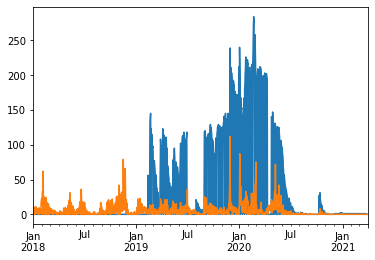

In [10]:
product = 'REFRIGERADOR ROC 31 BR'

df_stock[product].plot()
df_sales[product].plot()

In [19]:
ma = df_sales[product].rolling(window=7).mean().fillna(0)

In [21]:
df_stock[:'2019-01-01'][product] = 0

<ipython-input-21-20ff9eb75f6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock[:'2019-01-01'][product] = 0
